# Document Extraction Pipeline

This notebook implements a comprehensive RAG (Retrieval-Augmented Generation) system for processing nutritional disorder documents. The pipeline consists of several key stages:

**1. Document Parsing & Extraction**
- Uses LlamaParse to extract content from PDF documents in the docs/ folder
- Specifically extracts both text content and structured tables from nutritional disorder documents
- Handles table extraction with proper row/column structure preservation

**2. Semantic Chunking & Storage**
- Implements semantic text splitting using LangChain's SemanticChunker with 80th percentile threshold
- Creates 402 semantic chunks from the document corpus
- Stores chunks in ChromaDB vectorstore with OpenAI embeddings (text-embedding-ada-002)

**3. Hypothetical Question Generation**
- Generates 3 hypothetical questions for each semantic text chunk using GPT-4o-mini
- Generates 3 hypothetical questions for each extracted table
- Uses retry logic with exponential backoff to handle API rate limits
- Filters out empty tables and low-quality content

**4. Advanced Retrieval Methods**
- Implements structured retrieval using SelfQueryRetriever for intelligent metadata filtering
- Supports querying by category, disorder type, page number, and content type (text/table)
- Stores both original content and generated questions in separate vectorstore collections

**5. Multi-Modal Search Capabilities**
- Enables searching across both textual content and tabular data
- Supports queries about specific nutritional requirements, disorders, and treatments
- Provides contextual compression and cross-encoder reranking for improved relevance

The notebook demonstrates a LLM approach to medical document processing, combining structured data extraction with modern RAG techniques for enhanced question-answering capabilities.

In [1]:
!pip install numpy==1.25.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 29.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Installing the required libraries
!pip install openai==1.55.3 \
            langchain==0.2.7 \
            langchain-community==0.2.7\
             langchain-huggingface==0.0.3 \
             langchain-experimental==0.0.62 \
             langchain-openai==0.1.14 \
             chromadb==0.5.3 \
             sentence-transformers==3.0.1 \
             python-dotenv==1.0.1 \
             lark==1.1.9 \
             llama-index-core \
             llama-parse==0.5.11 \
             llama-index-readers-file \
             llama-index-llms-langchain \
             langgraph \
             groq \
             mem0ai

  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached jiter-0.10.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.21.4-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached build-1.3.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached fastapi-0.116.1-py3-none-any.whl.metadata (28 kB)
  Using cached uvicorn-0.35.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached opentelemetry_api-1.36.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.36.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached opentelemetry_sdk-1.36.0-py3-none-any.whl.metadata (1.5 kB)

In [3]:
import os
import chromadb
import numpy as np
np.float_ = np.float64

from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from llama_index.core import Settings

/Users/daniela_veloz/Workspace/nutri_care_ai/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Configuration

In [4]:
# declare constants
embedding_model_name="text-embedding-ada-002"
llm_model_name="gpt-4o-mini"

In [25]:
load_dotenv(override=True)
api_key = os.getenv("OPENAI_API_KEY")
llama_parse_api_key = os.getenv("LLAMA_PARSE_API_KEY")

In [9]:
"""
 This initializes the OpenAI embedding function for the Chroma vectorstore,
 using the provided endpoint, API key and the defined embedding model
"""
embedding_function = chromadb.utils.embedding_functions.OpenAIEmbeddingFunction(
    api_key=api_key,
    model_name=embedding_model_name
)

"""
 This initializes the OpenAI embedding function for the ChatOpenAI model,
 using the provided endpoint, API key, and the defined embedding model
"""
embedding_model = OpenAIEmbeddings(
    openai_api_key=api_key,
    model=embedding_model_name
)


In [7]:
"""
This initializes the Chat OpenAI model using the provided endpoint, API key, and
llm model
"""
llm = ChatOpenAI(
    openai_api_key=api_key,
    model=llm_model_name,
    streaming=False  # Explicitly disabling streaming
)

In [10]:
"""
Set the LLM and embedding model in the LlamaIndex settings. We need to set this up
was LlamaIndex uses Settings class to store all the configurations.

The Settings is a bundle of commonly used resources used during the indexing
and querying stage in a LlamaIndex workflow/application.

- llm: The LLM is used to respond to prompts and queries, and is responsible
for writing natural language responses.
- embedding_model: The embedding model is used to convert text to numerical
representations, used for calculating similarity and top-k retrieval.
"""
Settings.llm = llm
Settings.embedding = embedding_model

## Parsing and Extracting Tables from the Documents

In [11]:
# Setting up Async environment for Llama Parse
# Import necessary library for async operations in notebooks
import nest_asyncio

# Apply the nested async loop to allow async code execution in the notebook
nest_asyncio.apply()

In [27]:
# Import LlamaParse for parsing documents
from llama_parse import LlamaParse

# Initialize LlamaParse with desired settings
parser = LlamaParse(
    result_type="markdown",  # Specify the result format
    skip_diagonal_text=True,  # Skip diagonal text in the PDFs
    fast_mode=False,  # Use normal mode for parsing
    num_workers=9,  # Number of workers for parallel processing
    check_interval=10,  # Check interval for processing
    api_key=llama_parse_api_key  # API key for LlamaParse
)

## Parse PDF's content

In [28]:
import os

# List to store parsed JSON objects
json_objs = []

# Define the folder containing the documents
folder_path = "../../docs"

# Iterate through PDFs in the folder and parse content
for pdf in os.listdir(folder_path):
    if pdf.endswith(".pdf"):
        pdf_path = os.path.join(folder_path, pdf)
        json_objs.extend(parser.get_json_result(pdf_path))

Started parsing the file under job_id 0576dd6f-82b9-4fe3-a08a-1c2b33cc5087


In [29]:
# Pretty print JSON object for inspection
import json

print(json.dumps(json_objs[0], indent=4))

{
    "pages": [
        {
            "page": 1,
            "text": "The Merck Manual of Diagnosis & Therapy, 19th Edition    Chapter 1. Nutrition: General Considerations\n\n1 - Nutritional Disorders\n\nChapter 1. Nutrition: General Considerations\n\nIntroduction\n\nNutrition is the science of food and its relationship to health. Nutrients are chemicals in foods that are\nused by the body for growth, maintenance, and energy. Nutrients that cannot be synthesized by the body\nand thus must be derived from the diet are considered essential. They include vitamins, minerals, some\namino acids, and some fatty acids. Nutrients that the body can synthesize from other compounds,\nalthough they may also be derived from the diet, are considered nonessential. Macronutrients are\nrequired by the body in relatively large amounts; micronutrients are needed in minute amounts.\n\nLack of nutrients can result in deficiency syndromes (eg, kwashiorkor, pellagra) or other disorders (see p.\n9). Excess in

## Extracting Tables from Parsed JSON Objects

In [31]:
"""
 Initialize dictionaries to store page texts and tables
 - page_texts -> this dictionary will store the text content of each page
 - tables -> this dictionary will store the extracted tables from each page
"""

page_texts, tables = {}, {}

# Extract tables from the parsed JSON objects
for obj in json_objs:
    json_list = obj['pages'] #represents the pages of the pdf
    name = obj["file_path"].split("/")[-1]  # Extract the file name
    page_texts[name] = {}  # Initialize dictionary for page texts
    tables[name] = {}  # Initialize dictionary for tables

    for json_item in json_list:
        for component in json_item['items']:
            if component['type'] == 'table':  # Check if the component is a table
                tables[name][json_item['page']] = component['rows']  # Store table rows

In [32]:
# Display extracted tables for each PDF
for file_name, file_tables in tables.items():
    print(f"Tables from {file_name}:")
    for page_num, table_rows in file_tables.items():
        print(f"  Page {page_num}:")
        for row in table_rows:
            print(row)

Tables from Nutritional Disorders.pdf:
  Page 1:
['Food', 'Glycemic Index']
['Glucose', '100']
['Sucrose', '65']
['Starches', 'Variable']
['Fiber', '0']
  Page 3:
  Page 4:
  Page 24:
['Vitamin', 'Recommended Daily Intake']
['Biotin', '30 μg']
['Pantothenic Acid', '5 mg']
['Folate', 'Varies']
  Page 35:
['Inadequate absorption', 'Decreased acid secretion (elderly)']
['Blind loop syndrome', 'Fish tapeworm infestation']
['Inflammatory bowel disease', 'Surgical removal of ileal absorptive sites']
['Chronic pancreatitis', 'Gastric surgery']
['Malabsorption syndromes', 'AIDS']
['Use of certain drugs (e.g., antacids, metformin)', 'Repeated exposure to nitrous oxide']
['Genetic disorder (Imerslund-Graesbeck syndrome)', '']


## Semantic Chunking and Structured Retrieval

In [37]:
"""
  Initialize ChromaDB client
  EphemeralClient means that the database is created in memory and will be lost
  when the notebook ends
"""
chromadb_client = chromadb.EphemeralClient()

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given


In [38]:
"""
  This initializes the semantic text splitter, controlling how text is divided
   into meaningful chunks.
   We are using 'percentile' as breakpoint threshold, this mean the splitter will
   identify points in the text where the similarity between adjacent sentences falls
   below the 80th percentile. This helps to ensure that the chunks are semantically
   coherent and contain related information.
"""
semantic_text_splitter = SemanticChunker(
    embedding_model,
    breakpoint_threshold_type='percentile',
    breakpoint_threshold_amount=80
)

In [39]:
import os

# Step 1: Define the folder containing the documents
folder_path = "../../docs"

# Step 2: Initialize an empty list to store all semantic chunks
semantic_chunks = []

# Step 3: Initialize the PyPDFDirectoryLoader for the folder
pdf_loader = PyPDFDirectoryLoader(folder_path)

# Step 4: Load and split PDF documents into chunks using SemanticChunker
chunks = pdf_loader.load_and_split(semantic_text_splitter)

# Step 5: Extend the semantic_chunks list with the chunks from this folder
semantic_chunks.extend(chunks)

# Step 6: Get the total number of chunks
len(semantic_chunks)

402

## Creating and Storing Document Chunks in Chroma Vectorstore

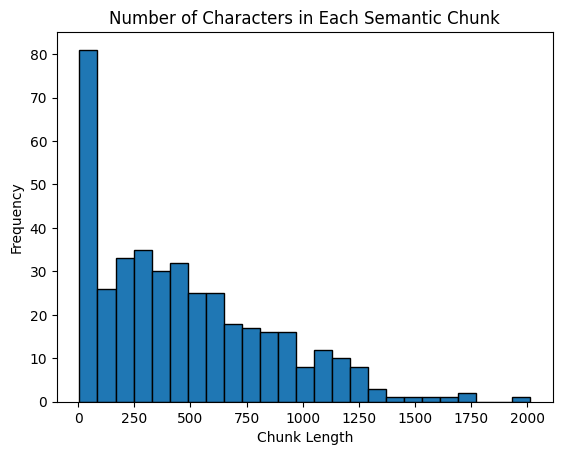

In [41]:
# Add IDs to the semantic chunks
semantic_chunks = [Document(id=i, page_content=d.page_content, metadata=d.metadata) for i, d in enumerate(semantic_chunks)]

# Plot a histogram of the number of characters in each semantic chunk
import matplotlib.pyplot as plt

chunk_lengths = [len(chunk.page_content) for chunk in semantic_chunks]
plt.hist(chunk_lengths, bins=25, edgecolor='black')
plt.xlabel('Chunk Length')
plt.ylabel('Frequency')
plt.title('Number of Characters in Each Semantic Chunk')
plt.show()

### Store the document chunks in Chroma vectorstore in batches

In [42]:
# Store the document chunks in Chroma vectorstore in batches
batch_size = 100  # Adjust the batch size as needed
for i in range(0, len(semantic_chunks), batch_size):
    batch = semantic_chunks[i : i + batch_size]
    semanticstore = Chroma.from_documents(
        batch,
        embedding_model,
        collection_name="semantic_chunks",
        persist_directory='./nutritional_db'
    )

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telem

### Perform similarity search in the vectorstore

In [43]:
# Example user query
user_input = "what are the minimal nutritional requirements for a 45 years old women?"

# Perform similarity search in the vectorstore
docs = semanticstore.similarity_search(user_input, k=5)

# Display retrieved documents
for i in docs:
    print("Source:", i.metadata['source'])
    print("Page:", i.metadata['page'], "\n")
    print(i.page_content)

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


Source: docs/Nutritional Disorders.pdf
Page: 3 

Daily dietary requirements for essential nutrients also depend on age, sex, weight, and metabolic and
physical activity. Every 5 yr, the Food and Nutrition Board of the National Academy of Sciences/National
Research Council and the US Department of Agriculture (USDA) issues the dietary reference intakes
(DRIs) for protein, energy, and some vitamins and minerals (see 
Tables 1-4
,
4-1
, and 
5-2
). For vitamins and minerals about which less is known, safe and adequate daily dietary
intakes are estimated.
Source: docs/Nutritional Disorders.pdf
Page: 2 

Nutrition: General Considerations
55
Source: docs/Nutritional Disorders.pdf
Page: 16 

The Mifflin-St. Jeor equation estimates RMR more precisely and with fewer errors than the commonly
used Harris-Benedict equation, usually providing results that are within 20% of those measured by
indirect calorimetry. The Mifflin-St. Jeor equation estimates RMR as follows:
Men
: kcal / day = 66 + (13.7 ×

### Structured Retrieval Using Self-Query Retriever

In [44]:
# Define metadata fields for structured retrieval
metadata_field_info = [
    AttributeInfo(
        name="Category",
        description="Category of the nutritional disorder (e.g., Undernutrition, Vitamin Deficiency, Obesity, etc.)",
        type="string"
    ),
    AttributeInfo(
        name="DisorderType",
        description="Specific type of nutritional disorder (e.g., Protein-Energy Malnutrition, Scurvy, Rickets, etc.)",
        type="string"
    ),
    AttributeInfo(
        name="Page",
        description="Page within the nutritional medical reference document that the information belongs to",
        type="integer"
    )
]

# Describe the content of the documents in the vectorstore
document_content_description = "information regarding Nutritional Disorders"

In [45]:
"""
 initialize structured retrieval using SelfQueryRetriever. This retriever is designed
 to perform more intelligent searches by using the llm to understand the users's query
 and refine the search based on the provided metadata.
"""
structured_retriever = SelfQueryRetriever.from_llm(
    llm,
    semanticstore,
    document_content_description,
    metadata_field_info
)

In [46]:
# Example user query
user_input = "what are the minimal nutritional requirements for a 45 years old women?"

# Perform structured retrieval using self-querying retriever
structured_retriever.invoke(user_input)

[Document(metadata={'page': 3, 'source': 'docs/Nutritional Disorders.pdf'}, page_content='Daily dietary requirements for essential nutrients also depend on age, sex, weight, and metabolic and\nphysical activity. Every 5 yr, the Food and Nutrition Board of the National Academy of Sciences/National\nResearch Council and the US Department of Agriculture (USDA) issues the dietary reference intakes\n(DRIs) for protein, energy, and some vitamins and minerals (see \nTables 1-4\n,\n4-1\n, and \n5-2\n). For vitamins and minerals about which less is known, safe and adequate daily dietary\nintakes are estimated.'),
 Document(metadata={'page': 2, 'source': 'docs/Nutritional Disorders.pdf'}, page_content='Nutrition: General Considerations\n55'),
 Document(metadata={'page': 11, 'source': 'docs/Nutritional Disorders.pdf'}, page_content='Undernutrition\n64'),
 Document(metadata={'page': 13, 'source': 'docs/Nutritional Disorders.pdf'}, page_content="of 175 kcal/kg and 4 g of protein/kg can be given. Tw

## Creating Hypothetical Questions and Storing in Chroma Vectorstore

In [47]:
# Define prompt for generating hypothetical questions
hypothetical_questions_prompt = """
Based on the following document about nutritional deficiencies, do the following:

1. Generate exactly 3 hypothetical questions that can be directly answered using the specific information in the document.
2. Focus on questions that are precisely relevant to the nutritional deficiencies.
3. Ensure questions require information unique to this document (not general knowledge).
4. Format as a simple numbered list (1., 2., 3.) without any introduction or conclusion text.
5. Make questions specific, well-formed, and diverse in their focus (symptoms, causes, treatments, etc.).
6. If the document lacks sufficient content about nutrition to formulate 3 meaningful questions, return an empty list.

Your response should contain ONLY the numbered list of questions or an empty list - no explanation, introduction, or additional commentary.

#document
{doc}
"""

In [48]:
# Generate hypothetical questions for each semantic chunk and store them in a structured format.

import time
import random
import openai
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
import requests
from requests.exceptions import HTTPError
from tqdm import tqdm

# Function to identify rate limit errors
def is_retry_error(exception):
    # Check for other errors containing rate limit text
    if isinstance(exception, Exception):
        error_str = str(exception)
        return "429" in error_str or "rate limit" in error_str.lower()

    return False

# Define a custom exception for rate limiting
class RateLimitException(Exception):
    pass

# Retry decorator with exponential backoff
@retry(
    retry=retry_if_exception_type(RateLimitException),
    wait=wait_exponential(multiplier=1, min=4, max=60),
    stop=stop_after_attempt(2),
    before_sleep=lambda retry_state: print(f"Rate limit hit, retrying in {retry_state.next_action.sleep} seconds...")
)
def generate_questions_with_retry(llm, prompt, document):
    try:
        response = llm.invoke(prompt.format(doc=document))
        return response.content
    except Exception as e:
        if is_retry_error(e):
            print(f"retriable error: {e}")
            raise RateLimitException(f"Rate limit reached: {e}")
        else:
            print(f"Other error: {e}")
            raise

# List to store documents with hypothetical questions
hypothetical_question_documents = []

total_chunks = len(semantic_chunks)
print(f"Total number of chunks: {total_chunks}")

# Generate hypothetical questions for each semantic chunk
for i, document in enumerate(tqdm(semantic_chunks, desc="Generating Questions")):
  print(f"Processing chunk {i + 1}/{total_chunks}")
  # Generate questions for the current document
  questions = generate_questions_with_retry(
                llm,
                hypothetical_questions_prompt,
                document)

   # Create metadata for the generated questions
  questions_metadata = {
        'original_content': document.page_content,  # Store the original chunk content
        'source': document.metadata['source'],  # Source document of the chunk
        'page': document.metadata['page'],  # Page number where the chunk appears
        'type': 'text'  # Indicate the content type
    }

    # Create and store the document containing generated questions
  hypothetical_question_documents.append(
        Document(
            id="doc_" + document.metadata['source'] + "_" + str(document.id),  # Generate a unique ID for each table
            page_content=questions,  # Store the generated questions
            metadata=questions_metadata  # Attach metadata
        )
    )


Total number of chunks: 402


Generating Questions:   0%|          | 0/402 [00:00<?, ?it/s]

Processing chunk 1/402


Generating Questions:   0%|          | 1/402 [00:00<05:01,  1.33it/s]

Processing chunk 2/402


Generating Questions:   0%|          | 2/402 [00:02<08:17,  1.24s/it]

Processing chunk 3/402


Generating Questions:   1%|          | 3/402 [00:03<09:31,  1.43s/it]

Processing chunk 4/402


Generating Questions:   1%|          | 4/402 [00:04<07:21,  1.11s/it]

Processing chunk 5/402


Generating Questions:   1%|          | 5/402 [00:06<08:05,  1.22s/it]

Processing chunk 6/402


Generating Questions:   1%|▏         | 6/402 [00:06<06:56,  1.05s/it]

Processing chunk 7/402


Generating Questions:   2%|▏         | 7/402 [00:08<08:10,  1.24s/it]

Processing chunk 8/402


Generating Questions:   2%|▏         | 8/402 [00:09<07:17,  1.11s/it]

Processing chunk 9/402


Generating Questions:   2%|▏         | 9/402 [00:11<08:46,  1.34s/it]

Processing chunk 10/402


Generating Questions:   2%|▏         | 10/402 [00:18<21:06,  3.23s/it]

Processing chunk 11/402


Generating Questions:   3%|▎         | 11/402 [00:20<18:42,  2.87s/it]

Processing chunk 12/402


Generating Questions:   3%|▎         | 12/402 [00:22<16:53,  2.60s/it]

Processing chunk 13/402


Generating Questions:   3%|▎         | 13/402 [00:23<12:40,  1.96s/it]

Processing chunk 14/402


Generating Questions:   3%|▎         | 14/402 [00:24<12:15,  1.90s/it]

Processing chunk 15/402


Generating Questions:   4%|▎         | 15/402 [00:25<09:42,  1.51s/it]

Processing chunk 16/402


Generating Questions:   4%|▍         | 16/402 [00:25<07:33,  1.17s/it]

Processing chunk 17/402


Generating Questions:   4%|▍         | 17/402 [00:26<06:05,  1.05it/s]

Processing chunk 18/402


Generating Questions:   4%|▍         | 18/402 [00:26<05:12,  1.23it/s]

Processing chunk 19/402


Generating Questions:   5%|▍         | 19/402 [00:28<06:46,  1.06s/it]

Processing chunk 20/402


Generating Questions:   5%|▍         | 20/402 [00:30<08:04,  1.27s/it]

Processing chunk 21/402


Generating Questions:   5%|▌         | 21/402 [00:31<08:34,  1.35s/it]

Processing chunk 22/402


Generating Questions:   5%|▌         | 22/402 [00:33<08:52,  1.40s/it]

Processing chunk 23/402


Generating Questions:   6%|▌         | 23/402 [00:33<07:22,  1.17s/it]

Processing chunk 24/402


Generating Questions:   6%|▌         | 24/402 [00:34<05:57,  1.06it/s]

Processing chunk 25/402


Generating Questions:   6%|▌         | 25/402 [00:34<04:51,  1.30it/s]

Processing chunk 26/402


Generating Questions:   6%|▋         | 26/402 [00:35<04:17,  1.46it/s]

Processing chunk 27/402


Generating Questions:   7%|▋         | 27/402 [00:35<03:42,  1.68it/s]

Processing chunk 28/402


Generating Questions:   7%|▋         | 28/402 [00:37<05:32,  1.12it/s]

Processing chunk 29/402


Generating Questions:   7%|▋         | 29/402 [00:38<06:36,  1.06s/it]

Processing chunk 30/402


Generating Questions:   7%|▋         | 30/402 [00:39<07:11,  1.16s/it]

Processing chunk 31/402


Generating Questions:   8%|▊         | 31/402 [00:40<05:52,  1.05it/s]

Processing chunk 32/402


Generating Questions:   8%|▊         | 32/402 [00:41<06:59,  1.13s/it]

Processing chunk 33/402


Generating Questions:   8%|▊         | 33/402 [00:43<07:50,  1.27s/it]

Processing chunk 34/402


Generating Questions:   8%|▊         | 34/402 [00:43<06:13,  1.02s/it]

Processing chunk 35/402


Generating Questions:   9%|▊         | 35/402 [00:44<05:05,  1.20it/s]

Processing chunk 36/402


Generating Questions:   9%|▉         | 36/402 [00:45<06:13,  1.02s/it]

Processing chunk 37/402


Generating Questions:   9%|▉         | 37/402 [00:46<05:01,  1.21it/s]

Processing chunk 38/402


Generating Questions:   9%|▉         | 38/402 [00:47<06:19,  1.04s/it]

Processing chunk 39/402


Generating Questions:  10%|▉         | 39/402 [00:49<07:35,  1.25s/it]

Processing chunk 40/402


Generating Questions:  10%|▉         | 40/402 [00:50<07:53,  1.31s/it]

Processing chunk 41/402


Generating Questions:  10%|█         | 41/402 [00:52<08:33,  1.42s/it]

Processing chunk 42/402


Generating Questions:  10%|█         | 42/402 [00:54<08:38,  1.44s/it]

Processing chunk 43/402


Generating Questions:  11%|█         | 43/402 [00:56<09:46,  1.63s/it]

Processing chunk 44/402


Generating Questions:  11%|█         | 44/402 [00:56<07:40,  1.29s/it]

Processing chunk 45/402


Generating Questions:  11%|█         | 45/402 [00:57<06:15,  1.05s/it]

Processing chunk 46/402


Generating Questions:  11%|█▏        | 46/402 [00:57<05:06,  1.16it/s]

Processing chunk 47/402


Generating Questions:  12%|█▏        | 47/402 [00:58<04:25,  1.34it/s]

Processing chunk 48/402


Generating Questions:  12%|█▏        | 48/402 [00:58<03:42,  1.59it/s]

Processing chunk 49/402


Generating Questions:  12%|█▏        | 49/402 [00:59<05:16,  1.12it/s]

Processing chunk 50/402


Generating Questions:  12%|█▏        | 50/402 [01:01<06:24,  1.09s/it]

Processing chunk 51/402


Generating Questions:  13%|█▎        | 51/402 [01:02<06:42,  1.15s/it]

Processing chunk 52/402


Generating Questions:  13%|█▎        | 52/402 [01:03<05:29,  1.06it/s]

Processing chunk 53/402


Generating Questions:  13%|█▎        | 53/402 [01:04<06:30,  1.12s/it]

Processing chunk 54/402


Generating Questions:  13%|█▎        | 54/402 [01:06<06:50,  1.18s/it]

Processing chunk 55/402


Generating Questions:  14%|█▎        | 55/402 [01:06<05:41,  1.02it/s]

Processing chunk 56/402


Generating Questions:  14%|█▍        | 56/402 [01:08<07:08,  1.24s/it]

Processing chunk 57/402


Generating Questions:  14%|█▍        | 57/402 [01:10<08:00,  1.39s/it]

Processing chunk 58/402


Generating Questions:  14%|█▍        | 58/402 [01:10<06:20,  1.11s/it]

Processing chunk 59/402


Generating Questions:  15%|█▍        | 59/402 [01:11<06:46,  1.19s/it]

Processing chunk 60/402


Generating Questions:  15%|█▍        | 60/402 [01:14<08:16,  1.45s/it]

Processing chunk 61/402


Generating Questions:  15%|█▌        | 61/402 [01:15<07:52,  1.39s/it]

Processing chunk 62/402


Generating Questions:  15%|█▌        | 62/402 [01:15<06:21,  1.12s/it]

Processing chunk 63/402


Generating Questions:  16%|█▌        | 63/402 [01:16<05:39,  1.00s/it]

Processing chunk 64/402


Generating Questions:  16%|█▌        | 64/402 [01:17<04:59,  1.13it/s]

Processing chunk 65/402


Generating Questions:  16%|█▌        | 65/402 [01:17<04:10,  1.35it/s]

Processing chunk 66/402


Generating Questions:  16%|█▋        | 66/402 [01:18<04:58,  1.12it/s]

Processing chunk 67/402


Generating Questions:  17%|█▋        | 67/402 [01:20<05:36,  1.00s/it]

Processing chunk 68/402


Generating Questions:  17%|█▋        | 68/402 [01:20<04:41,  1.19it/s]

Processing chunk 69/402


Generating Questions:  17%|█▋        | 69/402 [01:22<06:01,  1.08s/it]

Processing chunk 70/402


Generating Questions:  17%|█▋        | 70/402 [01:22<04:47,  1.16it/s]

Processing chunk 71/402


Generating Questions:  18%|█▊        | 71/402 [01:23<05:27,  1.01it/s]

Processing chunk 72/402


Generating Questions:  18%|█▊        | 72/402 [01:24<04:25,  1.24it/s]

Processing chunk 73/402


Generating Questions:  18%|█▊        | 73/402 [01:25<05:50,  1.07s/it]

Processing chunk 74/402


Generating Questions:  18%|█▊        | 74/402 [01:27<06:43,  1.23s/it]

Processing chunk 75/402


Generating Questions:  19%|█▊        | 75/402 [01:27<05:23,  1.01it/s]

Processing chunk 76/402


Generating Questions:  19%|█▉        | 76/402 [01:28<04:26,  1.23it/s]

Processing chunk 77/402


Generating Questions:  19%|█▉        | 77/402 [01:29<05:45,  1.06s/it]

Processing chunk 78/402


Generating Questions:  19%|█▉        | 78/402 [01:31<06:30,  1.21s/it]

Processing chunk 79/402


Generating Questions:  20%|█▉        | 79/402 [01:31<05:11,  1.04it/s]

Processing chunk 80/402


Generating Questions:  20%|█▉        | 80/402 [01:33<07:05,  1.32s/it]

Processing chunk 81/402


Generating Questions:  20%|██        | 81/402 [01:36<08:12,  1.53s/it]

Processing chunk 82/402


Generating Questions:  20%|██        | 82/402 [01:37<08:22,  1.57s/it]

Processing chunk 83/402


Generating Questions:  21%|██        | 83/402 [01:39<08:22,  1.58s/it]

Processing chunk 84/402


Generating Questions:  21%|██        | 84/402 [01:39<06:44,  1.27s/it]

Processing chunk 85/402


Generating Questions:  21%|██        | 85/402 [01:41<07:16,  1.38s/it]

Processing chunk 86/402


Generating Questions:  21%|██▏       | 86/402 [01:44<09:09,  1.74s/it]

Processing chunk 87/402


Generating Questions:  22%|██▏       | 87/402 [01:44<07:11,  1.37s/it]

Processing chunk 88/402


Generating Questions:  22%|██▏       | 88/402 [01:45<07:15,  1.39s/it]

Processing chunk 89/402


Generating Questions:  22%|██▏       | 89/402 [01:47<07:28,  1.43s/it]

Processing chunk 90/402


Generating Questions:  22%|██▏       | 90/402 [01:49<08:05,  1.56s/it]

Processing chunk 91/402


Generating Questions:  23%|██▎       | 91/402 [01:49<06:16,  1.21s/it]

Processing chunk 92/402


Generating Questions:  23%|██▎       | 92/402 [01:51<06:36,  1.28s/it]

Processing chunk 93/402


Generating Questions:  23%|██▎       | 93/402 [01:52<07:08,  1.39s/it]

Processing chunk 94/402


Generating Questions:  23%|██▎       | 94/402 [01:54<07:04,  1.38s/it]

Processing chunk 95/402


Generating Questions:  24%|██▎       | 95/402 [01:55<07:15,  1.42s/it]

Processing chunk 96/402


Generating Questions:  24%|██▍       | 96/402 [01:56<05:38,  1.11s/it]

Processing chunk 97/402


Generating Questions:  24%|██▍       | 97/402 [01:57<06:01,  1.19s/it]

Processing chunk 98/402


Generating Questions:  24%|██▍       | 98/402 [01:59<06:49,  1.35s/it]

Processing chunk 99/402


Generating Questions:  25%|██▍       | 99/402 [02:00<07:15,  1.44s/it]

Processing chunk 100/402


Generating Questions:  25%|██▍       | 100/402 [02:01<06:17,  1.25s/it]

Processing chunk 101/402


Generating Questions:  25%|██▌       | 101/402 [02:02<05:03,  1.01s/it]

Processing chunk 102/402


Generating Questions:  25%|██▌       | 102/402 [02:03<05:32,  1.11s/it]

Processing chunk 103/402


Generating Questions:  26%|██▌       | 103/402 [02:05<06:15,  1.26s/it]

Processing chunk 104/402


Generating Questions:  26%|██▌       | 104/402 [02:06<06:29,  1.31s/it]

Processing chunk 105/402


Generating Questions:  26%|██▌       | 105/402 [02:07<06:40,  1.35s/it]

Processing chunk 106/402


Generating Questions:  26%|██▋       | 106/402 [02:09<06:47,  1.38s/it]

Processing chunk 107/402


Generating Questions:  27%|██▋       | 107/402 [02:09<05:21,  1.09s/it]

Processing chunk 108/402


Generating Questions:  27%|██▋       | 108/402 [02:11<06:15,  1.28s/it]

Processing chunk 109/402


Generating Questions:  27%|██▋       | 109/402 [02:13<07:13,  1.48s/it]

Processing chunk 110/402


Generating Questions:  27%|██▋       | 110/402 [02:15<07:30,  1.54s/it]

Processing chunk 111/402


Generating Questions:  28%|██▊       | 111/402 [02:16<07:14,  1.49s/it]

Processing chunk 112/402


Generating Questions:  28%|██▊       | 112/402 [02:16<05:38,  1.17s/it]

Processing chunk 113/402


Generating Questions:  28%|██▊       | 113/402 [02:18<06:18,  1.31s/it]

Processing chunk 114/402


Generating Questions:  28%|██▊       | 114/402 [02:19<05:08,  1.07s/it]

Processing chunk 115/402


Generating Questions:  29%|██▊       | 115/402 [02:20<05:25,  1.13s/it]

Processing chunk 116/402


Generating Questions:  29%|██▉       | 116/402 [02:21<05:36,  1.18s/it]

Processing chunk 117/402


Generating Questions:  29%|██▉       | 117/402 [02:22<04:29,  1.06it/s]

Processing chunk 118/402


Generating Questions:  29%|██▉       | 118/402 [02:23<05:10,  1.09s/it]

Processing chunk 119/402


Generating Questions:  30%|██▉       | 119/402 [02:24<05:30,  1.17s/it]

Processing chunk 120/402


Generating Questions:  30%|██▉       | 120/402 [02:25<04:20,  1.08it/s]

Processing chunk 121/402


Generating Questions:  30%|███       | 121/402 [02:27<05:41,  1.22s/it]

Processing chunk 122/402


Generating Questions:  30%|███       | 122/402 [02:28<06:15,  1.34s/it]

Processing chunk 123/402


Generating Questions:  31%|███       | 123/402 [02:29<06:04,  1.31s/it]

Processing chunk 124/402


Generating Questions:  31%|███       | 124/402 [02:30<05:11,  1.12s/it]

Processing chunk 125/402


Generating Questions:  31%|███       | 125/402 [02:32<06:45,  1.46s/it]

Processing chunk 126/402


Generating Questions:  31%|███▏      | 126/402 [02:34<07:33,  1.64s/it]

Processing chunk 127/402


Generating Questions:  32%|███▏      | 127/402 [02:35<05:49,  1.27s/it]

Processing chunk 128/402


Generating Questions:  32%|███▏      | 128/402 [02:36<06:02,  1.32s/it]

Processing chunk 129/402


Generating Questions:  32%|███▏      | 129/402 [02:38<06:27,  1.42s/it]

Processing chunk 130/402


Generating Questions:  32%|███▏      | 130/402 [02:38<05:09,  1.14s/it]

Processing chunk 131/402


Generating Questions:  33%|███▎      | 131/402 [02:39<04:08,  1.09it/s]

Processing chunk 132/402


Generating Questions:  33%|███▎      | 132/402 [02:39<03:29,  1.29it/s]

Processing chunk 133/402


Generating Questions:  33%|███▎      | 133/402 [02:41<04:30,  1.01s/it]

Processing chunk 134/402


Generating Questions:  33%|███▎      | 134/402 [02:42<04:38,  1.04s/it]

Processing chunk 135/402


Generating Questions:  34%|███▎      | 135/402 [02:42<03:49,  1.16it/s]

Processing chunk 136/402


Generating Questions:  34%|███▍      | 136/402 [02:44<04:48,  1.08s/it]

Processing chunk 137/402


Generating Questions:  34%|███▍      | 137/402 [02:45<05:05,  1.15s/it]

Processing chunk 138/402


Generating Questions:  34%|███▍      | 138/402 [02:47<05:51,  1.33s/it]

Processing chunk 139/402


Generating Questions:  35%|███▍      | 139/402 [02:48<04:46,  1.09s/it]

Processing chunk 140/402


Generating Questions:  35%|███▍      | 140/402 [02:48<03:53,  1.12it/s]

Processing chunk 141/402


Generating Questions:  35%|███▌      | 141/402 [02:50<05:21,  1.23s/it]

Processing chunk 142/402


Generating Questions:  35%|███▌      | 142/402 [02:51<05:27,  1.26s/it]

Processing chunk 143/402


Generating Questions:  36%|███▌      | 143/402 [02:53<06:12,  1.44s/it]

Processing chunk 144/402


Generating Questions:  36%|███▌      | 144/402 [02:54<05:01,  1.17s/it]

Processing chunk 145/402


Generating Questions:  36%|███▌      | 145/402 [02:54<04:15,  1.01it/s]

Processing chunk 146/402


Generating Questions:  36%|███▋      | 146/402 [02:55<03:29,  1.22it/s]

Processing chunk 147/402


Generating Questions:  37%|███▋      | 147/402 [02:55<03:05,  1.38it/s]

Processing chunk 148/402


Generating Questions:  37%|███▋      | 148/402 [02:56<02:40,  1.58it/s]

Processing chunk 149/402


Generating Questions:  37%|███▋      | 149/402 [02:57<03:33,  1.19it/s]

Processing chunk 150/402


Generating Questions:  37%|███▋      | 150/402 [02:59<04:39,  1.11s/it]

Processing chunk 151/402


Generating Questions:  38%|███▊      | 151/402 [02:59<03:45,  1.11it/s]

Processing chunk 152/402


Generating Questions:  38%|███▊      | 152/402 [03:00<03:11,  1.30it/s]

Processing chunk 153/402


Generating Questions:  38%|███▊      | 153/402 [03:01<04:11,  1.01s/it]

Processing chunk 154/402


Generating Questions:  38%|███▊      | 154/402 [03:02<03:27,  1.20it/s]

Processing chunk 155/402


Generating Questions:  39%|███▊      | 155/402 [03:03<04:25,  1.08s/it]

Processing chunk 156/402


Generating Questions:  39%|███▉      | 156/402 [03:04<03:35,  1.14it/s]

Processing chunk 157/402


Generating Questions:  39%|███▉      | 157/402 [03:04<03:07,  1.30it/s]

Processing chunk 158/402


Generating Questions:  39%|███▉      | 158/402 [03:05<02:48,  1.45it/s]

Processing chunk 159/402


Generating Questions:  40%|███▉      | 159/402 [03:05<02:30,  1.62it/s]

Processing chunk 160/402


Generating Questions:  40%|███▉      | 160/402 [03:07<03:33,  1.13it/s]

Processing chunk 161/402


Generating Questions:  40%|████      | 161/402 [03:08<04:05,  1.02s/it]

Processing chunk 162/402


Generating Questions:  40%|████      | 162/402 [03:09<04:41,  1.17s/it]

Processing chunk 163/402


Generating Questions:  41%|████      | 163/402 [03:11<05:00,  1.26s/it]

Processing chunk 164/402


Generating Questions:  41%|████      | 164/402 [03:11<04:11,  1.06s/it]

Processing chunk 165/402


Generating Questions:  41%|████      | 165/402 [03:14<05:21,  1.35s/it]

Processing chunk 166/402


Generating Questions:  41%|████▏     | 166/402 [03:14<04:19,  1.10s/it]

Processing chunk 167/402


Generating Questions:  42%|████▏     | 167/402 [03:15<04:42,  1.20s/it]

Processing chunk 168/402


Generating Questions:  42%|████▏     | 168/402 [03:17<04:28,  1.15s/it]

Processing chunk 169/402


Generating Questions:  42%|████▏     | 169/402 [03:18<04:56,  1.27s/it]

Processing chunk 170/402


Generating Questions:  42%|████▏     | 170/402 [03:19<03:57,  1.02s/it]

Processing chunk 171/402


Generating Questions:  43%|████▎     | 171/402 [03:20<04:27,  1.16s/it]

Processing chunk 172/402


Generating Questions:  43%|████▎     | 172/402 [03:22<05:28,  1.43s/it]

Processing chunk 173/402


Generating Questions:  43%|████▎     | 173/402 [03:23<05:22,  1.41s/it]

Processing chunk 174/402


Generating Questions:  43%|████▎     | 174/402 [03:25<05:36,  1.48s/it]

Processing chunk 175/402


Generating Questions:  44%|████▎     | 175/402 [03:26<04:26,  1.17s/it]

Processing chunk 176/402


Generating Questions:  44%|████▍     | 176/402 [03:27<04:43,  1.25s/it]

Processing chunk 177/402


Generating Questions:  44%|████▍     | 177/402 [03:27<03:51,  1.03s/it]

Processing chunk 178/402


Generating Questions:  44%|████▍     | 178/402 [03:28<03:13,  1.16it/s]

Processing chunk 179/402


Generating Questions:  45%|████▍     | 179/402 [03:30<04:13,  1.14s/it]

Processing chunk 180/402


Generating Questions:  45%|████▍     | 180/402 [03:32<04:59,  1.35s/it]

Processing chunk 181/402


Generating Questions:  45%|████▌     | 181/402 [03:33<04:52,  1.32s/it]

Processing chunk 182/402


Generating Questions:  45%|████▌     | 182/402 [03:35<05:20,  1.46s/it]

Processing chunk 183/402


Generating Questions:  46%|████▌     | 183/402 [03:36<04:58,  1.36s/it]

Processing chunk 184/402


Generating Questions:  46%|████▌     | 184/402 [03:37<05:03,  1.39s/it]

Processing chunk 185/402


Generating Questions:  46%|████▌     | 185/402 [03:39<05:09,  1.43s/it]

Processing chunk 186/402


Generating Questions:  46%|████▋     | 186/402 [03:40<05:10,  1.44s/it]

Processing chunk 187/402


Generating Questions:  47%|████▋     | 187/402 [03:42<05:08,  1.44s/it]

Processing chunk 188/402


Generating Questions:  47%|████▋     | 188/402 [03:42<04:08,  1.16s/it]

Processing chunk 189/402


Generating Questions:  47%|████▋     | 189/402 [03:44<04:57,  1.40s/it]

Processing chunk 190/402


Generating Questions:  47%|████▋     | 190/402 [03:44<03:54,  1.11s/it]

Processing chunk 191/402


Generating Questions:  48%|████▊     | 191/402 [03:46<04:06,  1.17s/it]

Processing chunk 192/402


Generating Questions:  48%|████▊     | 192/402 [03:47<04:13,  1.21s/it]

Processing chunk 193/402


Generating Questions:  48%|████▊     | 193/402 [03:49<04:41,  1.35s/it]

Processing chunk 194/402


Generating Questions:  48%|████▊     | 194/402 [03:50<04:45,  1.37s/it]

Processing chunk 195/402


Generating Questions:  49%|████▊     | 195/402 [03:52<04:47,  1.39s/it]

Processing chunk 196/402


Generating Questions:  49%|████▉     | 196/402 [03:53<05:14,  1.53s/it]

Processing chunk 197/402


Generating Questions:  49%|████▉     | 197/402 [03:55<05:26,  1.59s/it]

Processing chunk 198/402


Generating Questions:  49%|████▉     | 198/402 [03:57<05:14,  1.54s/it]

Processing chunk 199/402


Generating Questions:  50%|████▉     | 199/402 [03:58<05:31,  1.63s/it]

Processing chunk 200/402


Generating Questions:  50%|████▉     | 200/402 [03:59<04:15,  1.27s/it]

Processing chunk 201/402


Generating Questions:  50%|█████     | 201/402 [03:59<03:29,  1.04s/it]

Processing chunk 202/402


Generating Questions:  50%|█████     | 202/402 [04:01<04:10,  1.25s/it]

Processing chunk 203/402


Generating Questions:  50%|█████     | 203/402 [04:02<03:18,  1.00it/s]

Processing chunk 204/402


Generating Questions:  51%|█████     | 204/402 [04:03<03:37,  1.10s/it]

Processing chunk 205/402


Generating Questions:  51%|█████     | 205/402 [04:04<03:38,  1.11s/it]

Processing chunk 206/402


Generating Questions:  51%|█████     | 206/402 [04:05<03:56,  1.20s/it]

Processing chunk 207/402


Generating Questions:  51%|█████▏    | 207/402 [04:06<03:14,  1.00it/s]

Processing chunk 208/402


Generating Questions:  52%|█████▏    | 208/402 [04:06<02:44,  1.18it/s]

Processing chunk 209/402


Generating Questions:  52%|█████▏    | 209/402 [04:08<03:09,  1.02it/s]

Processing chunk 210/402


Generating Questions:  52%|█████▏    | 210/402 [04:08<02:48,  1.14it/s]

Processing chunk 211/402


Generating Questions:  52%|█████▏    | 211/402 [04:11<04:25,  1.39s/it]

Processing chunk 212/402


Generating Questions:  53%|█████▎    | 212/402 [04:13<04:44,  1.50s/it]

Processing chunk 213/402


Generating Questions:  53%|█████▎    | 213/402 [04:14<04:56,  1.57s/it]

Processing chunk 214/402


Generating Questions:  53%|█████▎    | 214/402 [04:15<03:50,  1.23s/it]

Processing chunk 215/402


Generating Questions:  53%|█████▎    | 215/402 [04:16<03:54,  1.25s/it]

Processing chunk 216/402


Generating Questions:  54%|█████▎    | 216/402 [04:17<03:05,  1.00it/s]

Processing chunk 217/402


Generating Questions:  54%|█████▍    | 217/402 [04:18<03:23,  1.10s/it]

Processing chunk 218/402


Generating Questions:  54%|█████▍    | 218/402 [04:19<03:40,  1.20s/it]

Processing chunk 219/402


Generating Questions:  54%|█████▍    | 219/402 [04:21<03:35,  1.18s/it]

Processing chunk 220/402


Generating Questions:  55%|█████▍    | 220/402 [04:22<04:05,  1.35s/it]

Processing chunk 221/402


Generating Questions:  55%|█████▍    | 221/402 [04:24<04:03,  1.34s/it]

Processing chunk 222/402


Generating Questions:  55%|█████▌    | 222/402 [04:25<03:44,  1.25s/it]

Processing chunk 223/402


Generating Questions:  55%|█████▌    | 223/402 [04:26<03:36,  1.21s/it]

Processing chunk 224/402


Generating Questions:  56%|█████▌    | 224/402 [04:26<02:58,  1.00s/it]

Processing chunk 225/402


Generating Questions:  56%|█████▌    | 225/402 [04:28<03:25,  1.16s/it]

Processing chunk 226/402


Generating Questions:  56%|█████▌    | 226/402 [04:30<03:57,  1.35s/it]

Processing chunk 227/402


Generating Questions:  56%|█████▋    | 227/402 [04:31<04:08,  1.42s/it]

Processing chunk 228/402


Generating Questions:  57%|█████▋    | 228/402 [04:32<03:51,  1.33s/it]

Processing chunk 229/402


Generating Questions:  57%|█████▋    | 229/402 [04:34<03:57,  1.37s/it]

Processing chunk 230/402


Generating Questions:  57%|█████▋    | 230/402 [04:36<04:19,  1.51s/it]

Processing chunk 231/402


Generating Questions:  57%|█████▋    | 231/402 [04:36<03:20,  1.18s/it]

Processing chunk 232/402


Generating Questions:  58%|█████▊    | 232/402 [04:38<03:43,  1.31s/it]

Processing chunk 233/402


Generating Questions:  58%|█████▊    | 233/402 [04:39<03:58,  1.41s/it]

Processing chunk 234/402


Generating Questions:  58%|█████▊    | 234/402 [04:41<04:13,  1.51s/it]

Processing chunk 235/402


Generating Questions:  58%|█████▊    | 235/402 [04:42<04:04,  1.46s/it]

Processing chunk 236/402


Generating Questions:  59%|█████▊    | 236/402 [04:44<03:51,  1.39s/it]

Processing chunk 237/402


Generating Questions:  59%|█████▉    | 237/402 [04:45<03:55,  1.43s/it]

Processing chunk 238/402


Generating Questions:  59%|█████▉    | 238/402 [04:46<03:10,  1.16s/it]

Processing chunk 239/402


Generating Questions:  59%|█████▉    | 239/402 [04:47<03:16,  1.20s/it]

Processing chunk 240/402


Generating Questions:  60%|█████▉    | 240/402 [04:47<02:41,  1.00it/s]

Processing chunk 241/402


Generating Questions:  60%|█████▉    | 241/402 [04:49<03:11,  1.19s/it]

Processing chunk 242/402


Generating Questions:  60%|██████    | 242/402 [04:53<05:15,  1.97s/it]

Processing chunk 243/402


Generating Questions:  60%|██████    | 243/402 [04:54<04:52,  1.84s/it]

Processing chunk 244/402


Generating Questions:  61%|██████    | 244/402 [04:56<04:31,  1.72s/it]

Processing chunk 245/402


Generating Questions:  61%|██████    | 245/402 [04:57<04:03,  1.55s/it]

Processing chunk 246/402


Generating Questions:  61%|██████    | 246/402 [04:58<03:49,  1.47s/it]

Processing chunk 247/402


Generating Questions:  61%|██████▏   | 247/402 [04:59<02:58,  1.15s/it]

Processing chunk 248/402


Generating Questions:  62%|██████▏   | 248/402 [05:00<03:06,  1.21s/it]

Processing chunk 249/402


Generating Questions:  62%|██████▏   | 249/402 [05:01<02:32,  1.00it/s]

Processing chunk 250/402


Generating Questions:  62%|██████▏   | 250/402 [05:02<02:53,  1.14s/it]

Processing chunk 251/402


Generating Questions:  62%|██████▏   | 251/402 [05:03<02:57,  1.18s/it]

Processing chunk 252/402


Generating Questions:  63%|██████▎   | 252/402 [05:05<03:23,  1.35s/it]

Processing chunk 253/402


Generating Questions:  63%|██████▎   | 253/402 [05:06<03:20,  1.35s/it]

Processing chunk 254/402


Generating Questions:  63%|██████▎   | 254/402 [05:08<03:14,  1.31s/it]

Processing chunk 255/402


Generating Questions:  63%|██████▎   | 255/402 [05:10<04:21,  1.78s/it]

Processing chunk 256/402


Generating Questions:  64%|██████▎   | 256/402 [05:12<03:56,  1.62s/it]

Processing chunk 257/402


Generating Questions:  64%|██████▍   | 257/402 [05:13<03:45,  1.56s/it]

Processing chunk 258/402


Generating Questions:  64%|██████▍   | 258/402 [05:14<02:54,  1.21s/it]

Processing chunk 259/402


Generating Questions:  64%|██████▍   | 259/402 [05:15<03:03,  1.28s/it]

Processing chunk 260/402


Generating Questions:  65%|██████▍   | 260/402 [05:16<03:04,  1.30s/it]

Processing chunk 261/402


Generating Questions:  65%|██████▍   | 261/402 [05:18<02:59,  1.28s/it]

Processing chunk 262/402


Generating Questions:  65%|██████▌   | 262/402 [05:19<03:14,  1.39s/it]

Processing chunk 263/402


Generating Questions:  65%|██████▌   | 263/402 [05:21<03:27,  1.49s/it]

Processing chunk 264/402


Generating Questions:  66%|██████▌   | 264/402 [05:23<03:31,  1.54s/it]

Processing chunk 265/402


Generating Questions:  66%|██████▌   | 265/402 [05:24<03:43,  1.63s/it]

Processing chunk 266/402


Generating Questions:  66%|██████▌   | 266/402 [05:26<03:54,  1.72s/it]

Processing chunk 267/402


Generating Questions:  66%|██████▋   | 267/402 [05:28<03:53,  1.73s/it]

Processing chunk 268/402


Generating Questions:  67%|██████▋   | 268/402 [05:29<03:02,  1.36s/it]

Processing chunk 269/402


Generating Questions:  67%|██████▋   | 269/402 [05:29<02:27,  1.11s/it]

Processing chunk 270/402


Generating Questions:  67%|██████▋   | 270/402 [05:30<02:28,  1.12s/it]

Processing chunk 271/402


Generating Questions:  67%|██████▋   | 271/402 [05:31<02:02,  1.07it/s]

Processing chunk 272/402


Generating Questions:  68%|██████▊   | 272/402 [05:32<02:27,  1.13s/it]

Processing chunk 273/402


Generating Questions:  68%|██████▊   | 273/402 [05:34<02:31,  1.17s/it]

Processing chunk 274/402


Generating Questions:  68%|██████▊   | 274/402 [05:35<02:31,  1.19s/it]

Processing chunk 275/402


Generating Questions:  68%|██████▊   | 275/402 [05:36<02:28,  1.17s/it]

Processing chunk 276/402


Generating Questions:  69%|██████▊   | 276/402 [05:36<01:58,  1.06it/s]

Processing chunk 277/402


Generating Questions:  69%|██████▉   | 277/402 [05:38<02:12,  1.06s/it]

Processing chunk 278/402


Generating Questions:  69%|██████▉   | 278/402 [05:38<01:58,  1.05it/s]

Processing chunk 279/402


Generating Questions:  69%|██████▉   | 279/402 [05:40<02:11,  1.07s/it]

Processing chunk 280/402


Generating Questions:  70%|██████▉   | 280/402 [05:40<01:46,  1.15it/s]

Processing chunk 281/402


Generating Questions:  70%|██████▉   | 281/402 [05:42<02:02,  1.01s/it]

Processing chunk 282/402


Generating Questions:  70%|███████   | 282/402 [05:43<02:09,  1.08s/it]

Processing chunk 283/402


Generating Questions:  70%|███████   | 283/402 [05:45<02:37,  1.33s/it]

Processing chunk 284/402


Generating Questions:  71%|███████   | 284/402 [05:46<02:30,  1.28s/it]

Processing chunk 285/402


Generating Questions:  71%|███████   | 285/402 [05:46<01:58,  1.01s/it]

Processing chunk 286/402


Generating Questions:  71%|███████   | 286/402 [05:48<02:12,  1.14s/it]

Processing chunk 287/402


Generating Questions:  71%|███████▏  | 287/402 [05:49<02:32,  1.32s/it]

Processing chunk 288/402


Generating Questions:  72%|███████▏  | 288/402 [05:50<02:02,  1.08s/it]

Processing chunk 289/402


Generating Questions:  72%|███████▏  | 289/402 [05:51<02:14,  1.19s/it]

Processing chunk 290/402


Generating Questions:  72%|███████▏  | 290/402 [05:53<02:16,  1.22s/it]

Processing chunk 291/402


Generating Questions:  72%|███████▏  | 291/402 [05:54<02:11,  1.19s/it]

Processing chunk 292/402


Generating Questions:  73%|███████▎  | 292/402 [05:54<01:45,  1.04it/s]

Processing chunk 293/402


Generating Questions:  73%|███████▎  | 293/402 [05:56<02:04,  1.14s/it]

Processing chunk 294/402


Generating Questions:  73%|███████▎  | 294/402 [05:57<02:11,  1.22s/it]

Processing chunk 295/402


Generating Questions:  73%|███████▎  | 295/402 [05:58<02:06,  1.18s/it]

Processing chunk 296/402


Generating Questions:  74%|███████▎  | 296/402 [05:59<01:39,  1.07it/s]

Processing chunk 297/402


Generating Questions:  74%|███████▍  | 297/402 [06:00<01:57,  1.12s/it]

Processing chunk 298/402


Generating Questions:  74%|███████▍  | 298/402 [06:02<02:25,  1.40s/it]

Processing chunk 299/402


Generating Questions:  74%|███████▍  | 299/402 [06:03<01:53,  1.10s/it]

Processing chunk 300/402


Generating Questions:  75%|███████▍  | 300/402 [06:04<02:09,  1.27s/it]

Processing chunk 301/402


Generating Questions:  75%|███████▍  | 301/402 [06:06<02:31,  1.50s/it]

Processing chunk 302/402


Generating Questions:  75%|███████▌  | 302/402 [06:08<02:46,  1.66s/it]

Processing chunk 303/402


Generating Questions:  75%|███████▌  | 303/402 [06:10<02:55,  1.77s/it]

Processing chunk 304/402


Generating Questions:  76%|███████▌  | 304/402 [06:12<02:51,  1.75s/it]

Processing chunk 305/402


Generating Questions:  76%|███████▌  | 305/402 [06:12<02:10,  1.34s/it]

Processing chunk 306/402


Generating Questions:  76%|███████▌  | 306/402 [06:13<01:43,  1.08s/it]

Processing chunk 307/402


Generating Questions:  76%|███████▋  | 307/402 [06:15<02:13,  1.40s/it]

Processing chunk 308/402


Generating Questions:  77%|███████▋  | 308/402 [06:16<02:09,  1.38s/it]

Processing chunk 309/402


Generating Questions:  77%|███████▋  | 309/402 [06:17<01:44,  1.12s/it]

Processing chunk 310/402


Generating Questions:  77%|███████▋  | 310/402 [06:18<01:46,  1.15s/it]

Processing chunk 311/402


Generating Questions:  77%|███████▋  | 311/402 [06:19<01:30,  1.00it/s]

Processing chunk 312/402


Generating Questions:  78%|███████▊  | 312/402 [06:20<01:46,  1.18s/it]

Processing chunk 313/402


Generating Questions:  78%|███████▊  | 313/402 [06:21<01:24,  1.05it/s]

Processing chunk 314/402


Generating Questions:  78%|███████▊  | 314/402 [06:22<01:33,  1.07s/it]

Processing chunk 315/402


Generating Questions:  78%|███████▊  | 315/402 [06:24<01:49,  1.26s/it]

Processing chunk 316/402


Generating Questions:  79%|███████▊  | 316/402 [06:25<01:48,  1.26s/it]

Processing chunk 317/402


Generating Questions:  79%|███████▉  | 317/402 [06:26<01:25,  1.00s/it]

Processing chunk 318/402


Generating Questions:  79%|███████▉  | 318/402 [06:27<01:30,  1.08s/it]

Processing chunk 319/402


Generating Questions:  79%|███████▉  | 319/402 [06:27<01:14,  1.11it/s]

Processing chunk 320/402


Generating Questions:  80%|███████▉  | 320/402 [06:29<01:32,  1.12s/it]

Processing chunk 321/402


Generating Questions:  80%|███████▉  | 321/402 [06:29<01:13,  1.10it/s]

Processing chunk 322/402


Generating Questions:  80%|████████  | 322/402 [06:31<01:26,  1.09s/it]

Processing chunk 323/402


Generating Questions:  80%|████████  | 323/402 [06:31<01:08,  1.16it/s]

Processing chunk 324/402


Generating Questions:  81%|████████  | 324/402 [06:32<01:13,  1.06it/s]

Processing chunk 325/402


Generating Questions:  81%|████████  | 325/402 [06:34<01:23,  1.08s/it]

Processing chunk 326/402


Generating Questions:  81%|████████  | 326/402 [06:34<01:09,  1.10it/s]

Processing chunk 327/402


Generating Questions:  81%|████████▏ | 327/402 [06:36<01:21,  1.09s/it]

Processing chunk 328/402


Generating Questions:  82%|████████▏ | 328/402 [06:38<01:38,  1.33s/it]

Processing chunk 329/402


Generating Questions:  82%|████████▏ | 329/402 [06:39<01:34,  1.30s/it]

Processing chunk 330/402


Generating Questions:  82%|████████▏ | 330/402 [06:40<01:38,  1.36s/it]

Processing chunk 331/402


Generating Questions:  82%|████████▏ | 331/402 [06:42<01:34,  1.33s/it]

Processing chunk 332/402


Generating Questions:  83%|████████▎ | 332/402 [06:43<01:28,  1.27s/it]

Processing chunk 333/402


Generating Questions:  83%|████████▎ | 333/402 [06:43<01:11,  1.04s/it]

Processing chunk 334/402


Generating Questions:  83%|████████▎ | 334/402 [06:45<01:27,  1.28s/it]

Processing chunk 335/402


Generating Questions:  83%|████████▎ | 335/402 [06:46<01:24,  1.27s/it]

Processing chunk 336/402


Generating Questions:  84%|████████▎ | 336/402 [06:47<01:12,  1.10s/it]

Processing chunk 337/402


Generating Questions:  84%|████████▍ | 337/402 [06:48<01:02,  1.05it/s]

Processing chunk 338/402


Generating Questions:  84%|████████▍ | 338/402 [06:48<00:49,  1.29it/s]

Processing chunk 339/402


Generating Questions:  84%|████████▍ | 339/402 [06:49<01:00,  1.04it/s]

Processing chunk 340/402


Generating Questions:  85%|████████▍ | 340/402 [06:51<01:04,  1.04s/it]

Processing chunk 341/402


Generating Questions:  85%|████████▍ | 341/402 [06:51<00:52,  1.16it/s]

Processing chunk 342/402


Generating Questions:  85%|████████▌ | 342/402 [06:53<01:08,  1.15s/it]

Processing chunk 343/402


Generating Questions:  85%|████████▌ | 343/402 [06:53<00:56,  1.05it/s]

Processing chunk 344/402


Generating Questions:  86%|████████▌ | 344/402 [06:55<01:03,  1.10s/it]

Processing chunk 345/402


Generating Questions:  86%|████████▌ | 345/402 [06:56<01:04,  1.14s/it]

Processing chunk 346/402


Generating Questions:  86%|████████▌ | 346/402 [06:58<01:15,  1.35s/it]

Processing chunk 347/402


Generating Questions:  86%|████████▋ | 347/402 [06:58<00:58,  1.07s/it]

Processing chunk 348/402


Generating Questions:  87%|████████▋ | 348/402 [06:59<00:48,  1.11it/s]

Processing chunk 349/402


Generating Questions:  87%|████████▋ | 349/402 [07:00<00:57,  1.09s/it]

Processing chunk 350/402


Generating Questions:  87%|████████▋ | 350/402 [07:01<00:48,  1.06it/s]

Processing chunk 351/402


Generating Questions:  87%|████████▋ | 351/402 [07:02<00:52,  1.03s/it]

Processing chunk 352/402


Generating Questions:  88%|████████▊ | 352/402 [07:04<00:56,  1.13s/it]

Processing chunk 353/402


Generating Questions:  88%|████████▊ | 353/402 [07:05<00:55,  1.13s/it]

Processing chunk 354/402


Generating Questions:  88%|████████▊ | 354/402 [07:06<00:56,  1.18s/it]

Processing chunk 355/402


Generating Questions:  88%|████████▊ | 355/402 [07:08<01:00,  1.29s/it]

Processing chunk 356/402


Generating Questions:  89%|████████▊ | 356/402 [07:09<01:04,  1.40s/it]

Processing chunk 357/402


Generating Questions:  89%|████████▉ | 357/402 [07:10<00:50,  1.13s/it]

Processing chunk 358/402


Generating Questions:  89%|████████▉ | 358/402 [07:10<00:41,  1.06it/s]

Processing chunk 359/402


Generating Questions:  89%|████████▉ | 359/402 [07:11<00:37,  1.14it/s]

Processing chunk 360/402


Generating Questions:  90%|████████▉ | 360/402 [07:12<00:43,  1.04s/it]

Processing chunk 361/402


Generating Questions:  90%|████████▉ | 361/402 [07:14<00:46,  1.12s/it]

Processing chunk 362/402


Generating Questions:  90%|█████████ | 362/402 [07:14<00:40,  1.02s/it]

Processing chunk 363/402


Generating Questions:  90%|█████████ | 363/402 [07:16<00:43,  1.11s/it]

Processing chunk 364/402


Generating Questions:  91%|█████████ | 364/402 [07:16<00:35,  1.08it/s]

Processing chunk 365/402


Generating Questions:  91%|█████████ | 365/402 [07:18<00:40,  1.09s/it]

Processing chunk 366/402


Generating Questions:  91%|█████████ | 366/402 [07:19<00:42,  1.18s/it]

Processing chunk 367/402


Generating Questions:  91%|█████████▏| 367/402 [07:20<00:41,  1.20s/it]

Processing chunk 368/402


Generating Questions:  92%|█████████▏| 368/402 [07:21<00:32,  1.05it/s]

Processing chunk 369/402


Generating Questions:  92%|█████████▏| 369/402 [07:21<00:29,  1.13it/s]

Processing chunk 370/402


Generating Questions:  92%|█████████▏| 370/402 [07:23<00:32,  1.02s/it]

Processing chunk 371/402


Generating Questions:  92%|█████████▏| 371/402 [07:23<00:26,  1.15it/s]

Processing chunk 372/402


Generating Questions:  93%|█████████▎| 372/402 [07:25<00:36,  1.22s/it]

Processing chunk 373/402


Generating Questions:  93%|█████████▎| 373/402 [07:26<00:28,  1.01it/s]

Processing chunk 374/402


Generating Questions:  93%|█████████▎| 374/402 [07:26<00:23,  1.21it/s]

Processing chunk 375/402


Generating Questions:  93%|█████████▎| 375/402 [07:28<00:26,  1.02it/s]

Processing chunk 376/402


Generating Questions:  94%|█████████▎| 376/402 [07:29<00:31,  1.21s/it]

Processing chunk 377/402


Generating Questions:  94%|█████████▍| 377/402 [07:31<00:35,  1.43s/it]

Processing chunk 378/402


Generating Questions:  94%|█████████▍| 378/402 [07:32<00:32,  1.35s/it]

Processing chunk 379/402


Generating Questions:  94%|█████████▍| 379/402 [07:34<00:31,  1.37s/it]

Processing chunk 380/402


Generating Questions:  95%|█████████▍| 380/402 [07:35<00:30,  1.37s/it]

Processing chunk 381/402


Generating Questions:  95%|█████████▍| 381/402 [07:37<00:30,  1.47s/it]

Processing chunk 382/402


Generating Questions:  95%|█████████▌| 382/402 [07:38<00:24,  1.24s/it]

Processing chunk 383/402


Generating Questions:  95%|█████████▌| 383/402 [07:39<00:24,  1.30s/it]

Processing chunk 384/402


Generating Questions:  96%|█████████▌| 384/402 [07:40<00:23,  1.31s/it]

Processing chunk 385/402


Generating Questions:  96%|█████████▌| 385/402 [07:42<00:23,  1.38s/it]

Processing chunk 386/402


Generating Questions:  96%|█████████▌| 386/402 [07:43<00:21,  1.36s/it]

Processing chunk 387/402


Generating Questions:  96%|█████████▋| 387/402 [07:45<00:20,  1.39s/it]

Processing chunk 388/402


Generating Questions:  97%|█████████▋| 388/402 [07:46<00:19,  1.37s/it]

Processing chunk 389/402


Generating Questions:  97%|█████████▋| 389/402 [07:47<00:14,  1.11s/it]

Processing chunk 390/402


Generating Questions:  97%|█████████▋| 390/402 [07:48<00:14,  1.18s/it]

Processing chunk 391/402


Generating Questions:  97%|█████████▋| 391/402 [07:50<00:15,  1.38s/it]

Processing chunk 392/402


Generating Questions:  98%|█████████▊| 392/402 [07:50<00:11,  1.12s/it]

Processing chunk 393/402


Generating Questions:  98%|█████████▊| 393/402 [07:53<00:13,  1.52s/it]

Processing chunk 394/402


Generating Questions:  98%|█████████▊| 394/402 [07:53<00:09,  1.19s/it]

Processing chunk 395/402


Generating Questions:  98%|█████████▊| 395/402 [07:53<00:06,  1.05it/s]

Processing chunk 396/402


Generating Questions:  99%|█████████▊| 396/402 [07:54<00:04,  1.22it/s]

Processing chunk 397/402


Generating Questions:  99%|█████████▉| 397/402 [07:55<00:03,  1.37it/s]

Processing chunk 398/402


Generating Questions:  99%|█████████▉| 398/402 [07:55<00:02,  1.51it/s]

Processing chunk 399/402


Generating Questions:  99%|█████████▉| 399/402 [07:56<00:01,  1.64it/s]

Processing chunk 400/402


Generating Questions: 100%|█████████▉| 400/402 [07:56<00:01,  1.79it/s]

Processing chunk 401/402


Generating Questions: 100%|█████████▉| 401/402 [07:56<00:00,  1.94it/s]

Processing chunk 402/402


Generating Questions: 100%|██████████| 402/402 [07:57<00:00,  1.19s/it]


In [49]:
# Function to print a sample document with hypothetical questions
def print_sample(docs, index=0):
    print("ID:\n", docs[index].id, "\n")
    print("Metadata:")
    print(json.dumps(docs[index].metadata, indent=4), "\n")
    print("Hypothetical Questions:\n", docs[index].page_content)

# Print a sample document
print_sample(hypothetical_question_documents, 20)

ID:
 doc_docs/Nutritional Disorders.pdf_20 

Metadata:
{
    "original_content": "However, many nonnutrients in foods are\nuseful. For example, food additives (eg, preservatives, emulsifiers, antioxidants, stabilizers) improve the\nproduction and stability of foods. Trace components (eg, spices, flavors, odors, colors, phytochemicals,\nmany other natural products) improve appearance and taste. Fiber:\n Fiber occurs in various forms (eg, cellulose, hemicellulose, pectin, gums). It \nincreases GI motility,\nprevents constipation, and helps control diverticular disease. Fiber is thought to accelerate the elimination\nof cancer-causing substances produced by bacteria in the large intestine. Epidemiologic evidence\nsuggests an association between colon cancer and low fiber intake and a beneficial effect of fiber in\npatients with functional bowel disorders, Crohn's disease, obesity, and hemorrhoids. Soluble fiber\n(present in fruits, vegetables, oats, barley, and legumes) reduces the postpr

### Generating and storing Hypothetical Questions for Tables

In [50]:
# Define prompt for generating hypothetical questions for tables
hypothetical_questions_for_tables_prompt = """
  Based on the provided nutritional table, generate exactly 3 specific, well-formed questions related to nutritional deficiencies:

  Guidelines:
  1. Questions can be directly answered using ONLY the data in this table
  2. Focus on one or more of these topics:
    - Nutritional values and requirements
    - Dietary deficiencies and their effects
    - Metabolic disorders
    - Vitamin and mineral imbalances
    - Obesity and weight management
    - Related health conditions

  Format requirements:
  - Present as a simple numbered list (1., 2., 3.)
  - Include NO introduction, explanation, or concluding remarks
  - Questions should require the specific numerical data or relationships shown in the table
  - Questions should be diverse in focus (not all about the same nutrient or condition)

  If the table lacks sufficient nutritional information to formulate 3 substantive questions on these topics, return an empty list.

  Your response must contain ONLY the questions or an empty list.

  #table
  {table}
"""

In [55]:
# Generate hypothetical questions for tables in documents and store them as structured metadata.

# List to store documents with hypothetical questions for tables
hypothetical_question_tables = []  # Initialize an empty list to store generated questions

# Generate hypothetical questions for each table in the documents
for source in tables:
    for page in tables[source]:
        table_in_page = tables[source][page]
        # Skip empty tables
        if not table_in_page or table_in_page == []:
            print(f"Skipping empty table: {source}, page {page}")
            continue

        try:
            # Generate questions using the LLM
            response = llm.invoke(hypothetical_questions_for_tables_prompt.format(table=table_in_page))
            questions = response.content
        except Exception as e:
            print(e)
            questions = ""

        # Only add if questions were generated
        if questions.strip():
            # Metadata for each table
            questions_metadata = {
                'original_content': str(table_in_page),
                'source': source,
                'page': page,
                'type': 'table'
            }

            # Create a Document object for each set of generated questions
            hypothetical_question_tables.append(
                Document(
                    id="table_" + source + "_" + str(page),  # Generate a unique ID for each table
                    page_content=questions,  # Store the generated questions
                    metadata=questions_metadata  # Attach metadata for reference
                )
            )

Skipping empty table: Nutritional Disorders.pdf, page 3
Skipping empty table: Nutritional Disorders.pdf, page 4


In [54]:
# Function to print a sample document with hypothetical questions for tables
def print_sample(docs, index=0):
    if 0 <= index < len(docs):  # Check if index is within bounds
        print("ID:\n", docs[index].id, "\n")
        print("Metadata:")
        print(json.dumps(docs[index].metadata, indent=4), "\n")
        print("Hypothetical Questions:\n", docs[index].page_content)
    else:
        print(f"Index {index} is out of range for the list with length {len(docs)}.")


ID:
 table_Nutritional Disorders.pdf_4 

Metadata:
{
    "original_content": "[]",
    "source": "Nutritional Disorders.pdf",
    "page": 4,
    "type": "table"
} 

Hypothetical Questions:
 []


In [56]:
# See all available tables
print(f"Total documents: {len(hypothetical_question_tables)}")

# See all available tables
for i, doc in enumerate(hypothetical_question_tables):
print(f"Index {i}: {doc.id}")

Total documents: 3
Index 0: table_Nutritional Disorders.pdf_1
Index 1: table_Nutritional Disorders.pdf_24
Index 2: table_Nutritional Disorders.pdf_35


In [57]:
# Print a sample document, ensure index is within bounds
print_sample(hypothetical_question_tables, index=min(2, len(hypothetical_question_tables) - 1))

ID:
 table_Nutritional Disorders.pdf_35 

Metadata:
{
    "original_content": "[['Inadequate absorption', 'Decreased acid secretion (elderly)'], ['Blind loop syndrome', 'Fish tapeworm infestation'], ['Inflammatory bowel disease', 'Surgical removal of ileal absorptive sites'], ['Chronic pancreatitis', 'Gastric surgery'], ['Malabsorption syndromes', 'AIDS'], ['Use of certain drugs (e.g., antacids, metformin)', 'Repeated exposure to nitrous oxide'], ['Genetic disorder (Imerslund-Graesbeck syndrome)', '']]",
    "source": "Nutritional Disorders.pdf",
    "page": 35,
    "type": "table"
} 

Hypothetical Questions:
 1. What conditions related to inadequate absorption can lead to vitamin and mineral imbalances, as indicated by the table?  
2. How does chronic pancreatitis contribute to dietary deficiencies, based on the information provided?  
3. Which nutritional deficiencies are associated with surgical removal of ileal absorptive sites according to the table?  


### Storing Hypothetical Chunks of documents and tables as batches in Chroma Vectorstore

In [58]:
# Assign unique IDs to hypothetical questions and store them in the Chroma vector database in batches.

# Add IDs to the hypothetical questions for text semantic chunks
documents = [Document(id=chunk.id, page_content=chunk.page_content, metadata=chunk.metadata)  # Create Document objects
             for i, chunk in enumerate(hypothetical_question_documents)]  # Iterate over the semantic chunks and assign IDs

# Store the document chunks in Chroma vectorstore in batches
batch_size = 100  # Define batch size for storing chunks (adjust as needed)
for i in range(0, len(documents), batch_size):  # Iterate over chunks in batches
    batch = documents[i: i + batch_size]  # Extract a batch of documents

    # Store the batch in the Chroma vector database
    vectorstore = Chroma.from_documents(
        batch,  # Batch of documents to store
        embedding_model,  # Embedding function or model
        collection_name="hypotheticals",  # Define the collection name in Chroma
        persist_directory="./nutritional_db"  # Specify where to persist the database
    )


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telem

In [59]:
# Assign unique IDs to hypothetical questions for tables and store them in the Chroma vector database in batches.

# Add IDs to the hypothetical questions for tables
table_documents = [Document(id=table_chunk.id, page_content=table_chunk.page_content, metadata=table_chunk.metadata)  # Create Document objects
                   for i, table_chunk in enumerate(hypothetical_question_tables)]  # Iterate over table chunks and assign IDs

# Store the table chunks in Chroma vectorstore in batches
batch_size = 20  # Define batch size for storing chunks (adjust as needed)
for i in range(0, len(table_documents), batch_size):  # Iterate over table chunks in batches
    batch = table_documents[i: i + batch_size]  # Extract a batch of table documents

    # Store the batch in the Chroma vector database
    vectorstore = Chroma.from_documents(
        batch,  # Batch of table documents to store
        embedding_model,  # Embedding function or model
        collection_name="hypotheticals",  # Define the collection name in Chroma
        persist_directory="./nutritional_db"  # Specify where to persist the database
    )

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


## Testing Structured Retriever for Hypothetical Questions

In [60]:
# Define metadata fields for structured retrieval of hypothetical questions
metadata_field_info = [
    AttributeInfo(
        name="Category",
        description="Category of the nutritional disorder (e.g., Undernutrition, Vitamin Deficiency, Obesity, etc.)",
        type="string"
    ),
    AttributeInfo(
        name="DisorderType",
        description="Specific type of nutritional disorder (e.g., Protein-Energy Malnutrition, Scurvy, Rickets, etc.)",
        type="string"
    ),
    AttributeInfo(
        name="Page",
        description="Page within the nutritional medical reference document that the information belongs to",
        type="integer"
    ),
    AttributeInfo(
        name="original_content",
        description="Content in the original chunk",
        type="string"
    ),
    AttributeInfo(
        name="type",
        description="Original content type of the embedding. Value can be 'text' or 'table'.",
        type="string"
    )
]


# Describe the content of the document
document_content_description = "information regarding Nutritional Disorders"

In [61]:
# Initialize the self-querying retriever for hypothetical questions
structured_hyp_retriever = SelfQueryRetriever.from_llm(
    llm,  # LLM model
    vectorstore,  # Vectorstore
    document_content_description,  # Document content description
    metadata_field_info  # Metadata field info
)

In [62]:
# Example user query
user_input = "What is the effect of vegetarian diets?"

# Perform structured retrieval using the self-querying retriever
hypothetical_questions_retrieved = structured_hyp_retriever.invoke(user_input)

# Print sample retrieved documents
print(hypothetical_questions_retrieved)

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


[Document(metadata={'original_content': 'Later, nausea, vomiting, and diarrhea may occur.', 'page': 26, 'source': 'docs/Nutritional Disorders.pdf', 'type': 'text'}, page_content='1. What symptoms may occur later as a result of nutritional deficiencies according to the document?  \n2. Which gastrointestinal symptoms are mentioned in the document as potential effects of nutritional deficiencies?  \n3. Does the document specify any instances of nausea, vomiting, or diarrhea related to nutritional deficiencies?  '), Document(metadata={'original_content': 'A fruit-only\ndiet is not recommended because it is deficient in protein, Na, and many micronutrients. Fad diets:\n Some fad diets result in vitamin, mineral, and protein deficiencies; cardiac, renal, and\nmetabolic disorders; and sometimes death. Very low calorie diets (< 400 kcal/day) cannot sustain health\nfor long. Drugs and nutritional supplements:\n Many drugs (eg, appetite suppressants, digoxin) decrease\nappetite; others impair nu

In [63]:
# Example user query
user_input = "What are the signs of undernutrition?"

# Perform structured retrieval using the self-querying retriever
hypothetical_questions_retrieved = structured_hyp_retriever.invoke(user_input)

# Print sample retrieved documents
print(hypothetical_questions_retrieved)

[Document(metadata={'original_content': 'History:\n History should include questions about dietary intake (see\nFig. 2-1\n), recent changes in weight, and risk factors for undernutrition, including drug and alcohol use. Unintentional loss of ≥ 10% of usual body weight during a 3-mo period indicates a high probability of\nundernutrition. Social history should include questions about whether money is available for food and\nwhether the patient can shop and cook. Review of systems should focus on symptoms of nutritional deficiencies (see \nTable 2-1\n). For example,\nimpaired night vision may indicate vitamin A deficiency. Physical examination:\n Physical examination should include measurement of height and weight,\ninspection of body fat distribution, and anthropometric measurements of lean body mass.', 'page': 8, 'source': 'docs/Nutritional Disorders.pdf', 'type': 'text'}, page_content='1. What percentage of usual body weight loss over a 3-month period indicates a high probability of un